
## Mount Google Drive

In [6]:
# Colab 사용시
# from google.colab import drive
# drive.mount('/content/drive')

## Install

### 형태소 분석기 설치

In [7]:
# !java -version
# %pip install konlpy

## Import Library

In [2]:
import os
import pickle

import pandas as pd
import re

from konlpy.tag import Komoran, Okt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout,Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm


## GPU Setting

In [3]:
# Colab 사용시
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

## Hyper_parameters

In [4]:
# Colab
# DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/miso'

# Local
DATA_DIR = '/Users/inseoklee/Desktop/miso/data'
SAVE_DIR = '/Users/inseoklee/Desktop/miso/model/CNN'
LOAD_DIR = '/Users/inseoklee/Desktop/miso/model/CNN'

# MAX_LEN -> 패딩 단계에서 설정
EMBEDDING_DIM = 500
NUM_FILTERS = 512
KERNEL_SIZE = 5
HIDDEN_UNITS = 512
DROP_OUT = 0.5

EPOCHS = 20
VERBOSE = 1
BATCH_SIZE = 512
PATIENCE = 5
VALIDATION_SPLIT=0.2

OUTPUT = 7

## Load Data

In [5]:
df = pd.read_csv(DATA_DIR+'/processed_sentiment.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37212 entries, 0 to 37211
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    37212 non-null  object
 1   label   37212 non-null  object
dtypes: object(2)
memory usage: 581.6+ KB


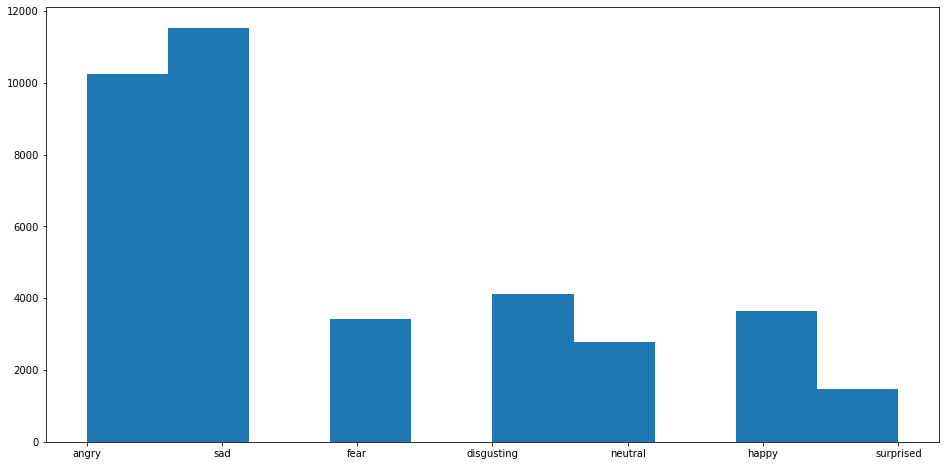

In [7]:
label = df['label']

plt.figure(figsize=(16, 8))
plt.hist(label)
plt.show()

### Train, Test split

In [27]:
X = df.text
y = df.label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=34, stratify=y
)

In [9]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('\nX_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (29769,)
y_train shape:  (29769,)

X_test shape:  (7443,)
y_test shape:  (7443,)


## Train Data PreProcessing

### Komoran을 이용한 품사(불용어) 제거 및 토큰화

In [10]:
komoran = Komoran()

# 불용어(Stop Words) 제거
stop_pos_tags =  ['IC', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX',
                   'EF', 'ETN', 'ETM', 'XSA', 'SF', 'SP', 'SS', 'SE', 'SO', 'SL', 'SH',
                   'SW', 'NF', 'NV', 'SN', 'NA']

#어간 원형 복원 (Lemmatization)
#동사와 형용사의 경우에는 어간(Stem)에 '다'를 붙여서 기본형으로 복원
def tokenize(corpus, stop_pos_tags):
    result = []
    pairs = komoran.pos(corpus)
    for pair in pairs:
        morph, pos = pair
        if pos not in stop_pos_tags:
            if pos in ['VV', 'VA', 'VX', 'VCP', 'VCN']:
                morph = morph + '다'
            result.append(morph)
    return result

[0.004s][warning][os,thread] Attempt to protect stack guard pages failed (0x000000016d2c8000-0x000000016d2d4000).
[0.004s][warning][os,thread] Attempt to deallocate stack guard pages failed.


In [11]:
# 토큰을 만들고 리스트에 저장
clean_train_text = []
for sample in tqdm(X_train):
    clean_train_text.append(tokenize(sample, stop_pos_tags))

100%|██████████| 29769/29769 [00:10<00:00, 2849.40it/s]


In [12]:
clean_train_text[:5]

[['안', '그래도', '카페', '가다', '참', '이다', '바람', '좀', '쐬다'],
 ['그렇다', '니깐', '말', '이다', '당장', '버리다', '어야', '하다', '겠'],
 ['약속', '있다', '어서', '친구', '기다리다', '는데', '친구', '안와'],
 ['나', '그러니까', '너무', '힘들다'],
 ['내', '너무', '갖다', '고', '싶다', '었', '걸다', 'ㄴ데', '받다', '아서', '정말', '기분', '좋다']]

## Test Data PreProcessing

### Komoran을 이용한 품사(불용어) 제거 및 토큰화

In [13]:
# 토큰을 만들고 리스트에 저장
clean_test_text = []
for sample in tqdm(X_test):
    clean_test_text.append(tokenize(sample, stop_pos_tags))

100%|██████████| 7443/7443 [00:01<00:00, 3769.12it/s]


### 토큰 데이터 벡터화(토큰을 숫자로 변환하고 tokenizer를 파일에 저장)

In [14]:
tokenizer_name = 'tokenizer.pickle'
save_path = os.path.join(SAVE_DIR, tokenizer_name)

tokenizer = Tokenizer(oov_token = True)

try:
    tokenizer.fit_on_texts(clean_train_text)
    train_sequences = tokenizer.texts_to_sequences(clean_train_text)
    test_sequences = tokenizer.texts_to_sequences(clean_test_text)
except:
    print('Already tokenized')

with open(save_path, 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

vocab_size = len(tokenizer.word_index)+1 # 단어의 수
vocab_size

train_sequences[:5]

[[14, 143, 1433, 32, 596, 9, 545, 41, 723],
 [26, 561, 57, 9, 368, 78, 68, 3, 16],
 [65, 7, 24, 31, 135, 13, 31, 879],
 [10, 481, 11, 45],
 [25, 11, 235, 5, 54, 6, 144, 93, 89, 21, 47, 86, 30]]

In [15]:
token_dic = tokenizer.word_counts
d2 = sorted(token_dic.items(), key=lambda x: x[1], reverse=True)
print("sorted")
print(d2)

sorted
[('았', 9138), ('하다', 7952), ('하', 7899), ('고', 7674), ('었', 7090), ('있다', 5091), ('어', 4450), ('이다', 4444), ('나', 4039), ('너무', 4039), ('게', 3838), ('는데', 3775), ('안', 3686), ('아', 3652), ('겠', 3403), ('보다', 3389), ('같다', 3354), ('없다', 3337), ('되다', 3313), ('아서', 3267), ('거', 3000), ('것', 2616), ('어서', 2453), ('내', 2267), ('그렇다', 2227), ('오다', 2204), ('지', 2139), ('들', 2139), ('좋다', 2104), ('친구', 1875), ('가다', 1843), ('주다', 1843), ('다', 1747), ('한', 1742), ('일', 1706), ('아야', 1643), ('지금', 1606), ('않다', 1576), ('사람', 1555), ('좀', 1453), ('나다', 1427), ('시', 1398), ('집', 1354), ('힘들다', 1350), ('잘', 1339), ('정말', 1328), ('많이', 1209), ('들다', 1172), ('모르다', 1122), ('알다', 1108), ('그', 1081), ('수', 1050), ('싶다', 1045), ('번', 1035), ('먹다', 1033), ('말', 1027), ('아직', 1018), ('못', 1011), ('지다', 1010), ('시간', 1003), ('니까', 999), ('면', 997), ('회사', 972), ('약속', 967), ('또', 965), ('생각', 949), ('어야', 945), ('다치다', 936), ('만나다', 917), ('되', 909), ('괜찮다', 904), ('진짜', 873), ('때', 860), ('아니다', 

### Padding

텍스트의 최대 길이 : 52
텍스트의 평균 길이 : 10.53609459504854


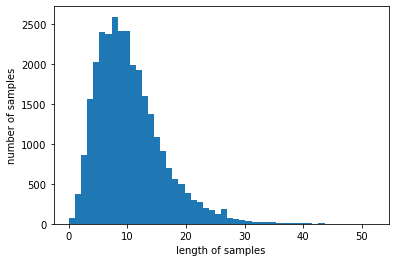

In [16]:
print('텍스트의 최대 길이 :',max(len(text) for text in train_sequences))
print('텍스트의 평균 길이 :',sum(map(len, train_sequences))/len(train_sequences))
plt.hist([len(text) for text in train_sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
trunc_type = 'post'
padding_type = 'post'
MAX_LEN = int(max(len(text) for text in train_sequences) * 95 / 100)

X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)
X_test= pad_sequences(test_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)

In [18]:
print(X_train[:3])

[[  14  143 1433   32  596    9  545   41  723    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [  26  561   57    9  368   78   68    3   16    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [  65    7   24   31  135   13   31  879    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [  10  481   11   45    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0 

### Labeling

In [28]:
y_train.unique()

array(['sad', 'disgusting', 'angry', 'happy', 'fear', 'surprised',
       'neutral'], dtype=object)

In [29]:
emo_dic = {
    'sad': 0, 'disgusting': 1, 'angry': 2, 'happy': 3, 'fear': 4, 'surprised': 5,
       'neutral': 6
}

In [30]:
y_train = y_train.replace(emo_dic)
y_test = y_test.replace(emo_dic)
y_train.unique()

array([0, 1, 2, 3, 4, 5, 6])

## Model definition

In [31]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, mask_zero=True, input_length=MAX_LEN))
model.add(Dropout(DROP_OUT))
model.add(Conv1D(NUM_FILTERS, KERNEL_SIZE, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(HIDDEN_UNITS, activation='relu'))
model.add(Dropout(DROP_OUT))
model.add(Dense(OUTPUT, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=VERBOSE, save_best_only=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Metal device set to: Apple M1


2022-07-15 10:39:09.084234: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-15 10:39:09.084420: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Train Model

In [32]:
history = model.fit(
    X_train, y_train, epochs=EPOCHS, callbacks=[es, mc], batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT
)

Epoch 1/20


2022-07-15 10:39:11.103366: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: in user code:

    File "/Users/inseoklee/miniforge3/envs/nlp/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/inseoklee/miniforge3/envs/nlp/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/inseoklee/miniforge3/envs/nlp/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/inseoklee/miniforge3/envs/nlp/lib/python3.10/site-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/Users/inseoklee/miniforge3/envs/nlp/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "conv1d" (type Conv1D).
    
    Negative dimension size caused by subtracting 5 from 1 for '{{node sequential/conv1d/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential/conv1d/Conv1D/ExpandDims, sequential/conv1d/Conv1D/ExpandDims_1)' with input shapes: [?,1,1,500], [1,5,500,512].
    
    Call arguments received by layer "conv1d" (type Conv1D):
      • inputs=tf.Tensor(shape=(None, 1, 500), dtype=float32)


## Test Model

In [34]:
loaded_model = load_model('best_model.h5')
loss, acc = loaded_model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', acc)

ValueError: in user code:

    File "/Users/inseoklee/miniforge3/envs/nlp/lib/python3.10/site-packages/keras/engine/training.py", line 1557, in test_function  *
        return step_function(self, iterator)
    File "/Users/inseoklee/miniforge3/envs/nlp/lib/python3.10/site-packages/keras/engine/training.py", line 1546, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/inseoklee/miniforge3/envs/nlp/lib/python3.10/site-packages/keras/engine/training.py", line 1535, in run_step  **
        outputs = model.test_step(data)
    File "/Users/inseoklee/miniforge3/envs/nlp/lib/python3.10/site-packages/keras/engine/training.py", line 1499, in test_step
        y_pred = self(x, training=False)
    File "/Users/inseoklee/miniforge3/envs/nlp/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "conv1d_34" (type Conv1D).
    
    Negative dimension size caused by subtracting 5 from 1 for '{{node sequential_34/conv1d_34/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_34/conv1d_34/Conv1D/ExpandDims, sequential_34/conv1d_34/Conv1D/ExpandDims_1)' with input shapes: [?,1,1,500], [1,5,500,512].
    
    Call arguments received by layer "conv1d_34" (type Conv1D):
      • inputs=tf.Tensor(shape=(None, 1, 500), dtype=float32)


### Visualization

NameError: name 'history' is not defined

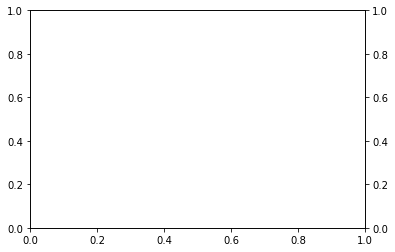

In [33]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Save Model

In [26]:
model_name = 'trained_model.h5'

# Save model and weights
model_path = os.path.join(SAVE_DIR, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/inseoklee/Desktop/miso/model/CNN/trained_model.h5 


## Evaluation

### confusion matrix

In [27]:
y_pred = loaded_model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

 37/233 [===>..........................] - ETA: 0s

2022-07-13 15:54:37.100236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - 1s 5ms/step
[0 0 1 ... 0 3 1]


In [35]:
# constant for classes
classes = ('sad', 'disgusting' , 'angry', 'happy', 'fear', 'surprised', 'neutral')

# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/cf_matrix.sum(axis=1).reshape(7, 1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig(SAVE_DIR + '/output.png')

NameError: name 'y_pred' is not defined

### precision, recall, f1 score

In [29]:
acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred, average='macro')
re_score = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')
print("accuracy_score: ", acc_score)
print("precision_score: ", prec_score)
print("recall_score: ", re_score)
print("f1_score: ", f1_score)

accuracy_score:  0.8895606610237807
precision_score:  0.8923037546334015
recall_score:  0.8730931242274428
f1_score:  0.8821658933344488


## Load Model

In [30]:
def load_tokenizer(path):
    with open(path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer

model_name = 'trained_model.h5'
tokenizer_name = 'tokenizer.pickle'
model_path = os.path.join(LOAD_DIR, model_name)
tokenizer_path = os.path.join(LOAD_DIR, tokenizer_name)

model = load_model(model_path)
tokenizer = load_tokenizer(tokenizer_path)


In [31]:
def getResult(predict) :
    highest = 0
    highestIdx = 0
    for x in range (0,len(predict)) :
        if(predict[x] > highest) :
            highestIdx = x
            highest =predict[x]
    return highestIdx

def predict_sentiment(text, model):
    tokens = []
    tokenized = tokenize(text, stop_pos_tags)
    if(len(tokenized) == 0) :
        return "너무 짧아"
    tokens.append(tokenized)
    tokens = tokenizer.texts_to_sequences(tokens)
    x_test = pad_sequences(tokens, maxlen=MAX_LEN)
    predict = model.predict(x_test)
    # print(predict)
    result = getResult(predict[0])
    if result == 0 :
        return 'angry'
    elif result == 1 :
        return 'sad'
    elif result == 2 :
        return 'fear'
    elif result == 3 :
        return 'disgusting'
    elif result == 4 :
        return 'neutral'
    elif result == 5 :
        return 'happy'
    elif result == 6 :
        return 'surprised'

1/1 [==============================] - 0s 113ms/step
[[1.26953665e-02 9.87060905e-01 2.14110678e-05 3.25944129e-05
  2.52502650e-05 5.68879898e-07 1.63868899e-04]]


2022-07-13 15:54:39.210731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


'sad'

In [ ]:
predict_sentiment("너 엄마가 일찍 들어오라고 했어 안했어.", model)

In [ ]:
predict_sentiment("친구가 다쳐서 병문안 가야돼.", model)